<a href="https://colab.research.google.com/github/lfedros/Dbs/blob/main/suite2p_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#link your google drive to get the data. Make sure you have added the shared folder:
# \suite2p_tutorial
# to your \MyDrive as a shortcut
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy
!pip install matplotlib

import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Polygon

In [3]:
#load data

# ROIs signals
F = np.load('/content/drive/MyDrive/suite2p_tutorial/Data/1P_miniscope/Long/1/suite2p/plane0/F.npy', allow_pickle=True)
# neuropil signals
Fneu = np.load('/content/drive/MyDrive/suite2p_tutorial/Data/1P_miniscope/Long/1/suite2p/plane0/Fneu.npy', allow_pickle=True)
# spks deconvolved rates
spks = np.load('/content/drive/MyDrive/suite2p_tutorial/Data/1P_miniscope/Long/1/suite2p/plane0/spks.npy', allow_pickle=True)
# stat contains statistics about each detected ROI
stat = np.load('/content/drive/MyDrive/suite2p_tutorial/Data/1P_miniscope/Long/1/suite2p/plane0/stat.npy', allow_pickle=True)
# ops contains the parameters used to run s2p, plus some other that are computed - e.g. mean images, registration target etc
ops =  np.load('/content/drive/MyDrive/suite2p_tutorial/Data/1P_miniscope/Long/1/suite2p/plane0/ops.npy', allow_pickle=True)
ops = ops.item()
# classifier info
iscell = np.load('/content/drive/MyDrive/suite2p_tutorial/Data/1P_miniscope/Long/1/suite2p/plane0/iscell.npy', allow_pickle=True)

In [4]:
#select cells and define intermediate values
neurons_raw = F[iscell[:, 0].astype(bool), :]
nN, nFrames = neurons_raw.shape
frameTime = np.arange(1, nFrames + 1) / ops['fs']

In [5]:
#correct for neuropil and zscore
neuropil = Fneu[iscell[:,0].astype(bool),:]
neurons = F - Fneu
neurons = zscore(neurons, axis=1)

In [ ]:
#remove frame artifacts

# Calculate difference of mean values across columns
dPop = np.diff(np.mean(neurons, axis=0), prepend=0)

# Identify artifacts where change is > 50
artefacts = np.abs(dPop) > 50

# Set artifact columns to NaN
neurons[:, artefacts] = np.nan
Fneu[:, artefacts] = np.nan

#define a function to interpolate across the nans
def interpNaN(array):
    array = array.copy()
    nans = np.isnan(array)
    x = nans.nonzero()[0]
    xp = (~nans).nonzero()[0]
    fp = array[~nans]
    array[nans] = np.interp(x, xp, fp)
    return array

# If artifacts found, interpolate NaNs along each row
if np.sum(artefacts) > 0:
    for iN in range(nN):
        neurons[iN, :] = interpNaN(neurons[iN, :])
        Fneu[iN, :] = interpNaN(Fneu[iN, :])


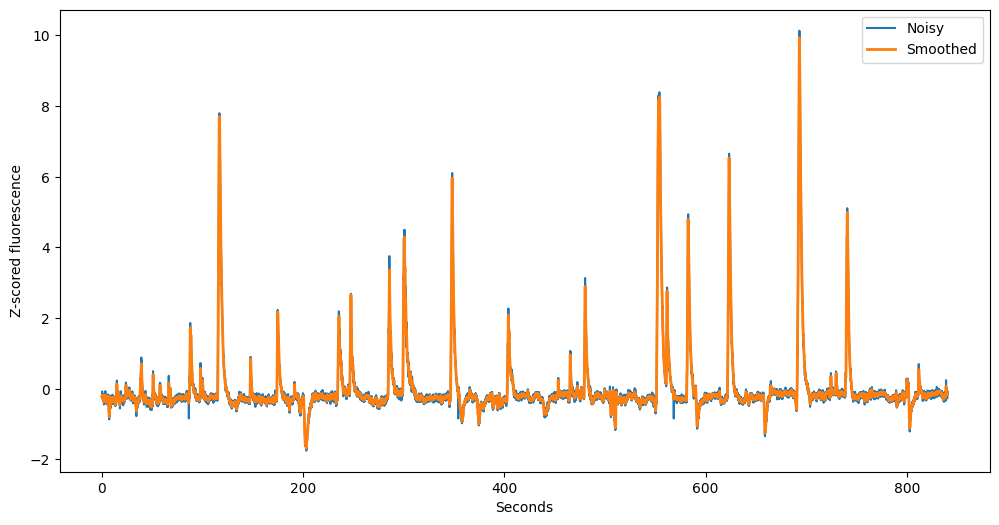

In [6]:
#smooth
neurons_smooth = gaussian_filter1d(neurons, sigma=1.5, axis=1)
plt.figure(figsize=(12, 6))
plt.plot(frameTime, neurons[10,:], label='Noisy')
plt.plot(frameTime, neurons_smooth[10,:], label='Smoothed', linewidth=2)
plt.xlabel('Seconds')
plt.ylabel('Z-scored fluorescence')
plt.legend()
plt.show()

In [ ]:
#debleach?

In [ ]:
#plot first n neurons' z-scored fluorescence traces
n = 1 #how many neurons' traces do you want to visualize
offset = 5 #so the traces don't overlap
plt.figure(figsize=(12, 6))
for i in range(min(n, neurons.shape[0])):
    plt.plot(frameTime, neurons[i] + i * offset, label=f'Neuron {i+1}')
plt.xlabel('Seconds')
plt.ylabel('Z-scored fluorescence')
plt.title('Fluorescence traces')
plt.show()

In [ ]:
#heatmap of many neurons' activity
from matplotlib.ticker import MaxNLocator
fluo_interval = 10 #to visualize every nth neuron in the recording
plt.figure(figsize=(10, 8))
plt.imshow(neurons[0::fluo_interval,:], aspect='auto', cmap='viridis')
plt.colorbar(label='Z-scored fluorescence')
plt.xlabel('Frame')
plt.ylabel('Neuron')
plt.title('Heatmap of neural activity')
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
#raster plot of deconvolved spikes
spike_interval = 5 #to visualize every nth neuron in the recording
plt.figure(figsize=(12, 6))
plt.imshow(spks[0::spike_interval,:], aspect='auto', cmap='Greys', interpolation='none')
plt.xlabel('Frame')
plt.ylabel('Neurons')
plt.title('Raster plot')
plt.show()


In [ ]:
#But this is hard to make sense of. Let's sort the neurons based on the similarity of their activity.
!pip install rastermap
from rastermap import Rastermap, utils
n_neurons, n_time = spks.shape
print(f"{n_neurons} neurons by {n_time} timepoints")
spks = zscore(spks, axis=1)
model = Rastermap(n_clusters=50, # number of clusters to compute
                  n_PCs=128, # number of PCs to use
                  locality=0.75, # locality in sorting to find sequences (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                ).fit(spks)
y = model.embedding
isort = model.isort #this is the array we use to sort our data
sorted_data = spks[isort, :]
plt.figure(figsize=(12, 6))
plt.imshow(sorted_data, aspect='auto', cmap='Greys', interpolation='none')
plt.xlabel('Frame')
plt.ylabel('Neurons (sorted)')
plt.title('Raster plot sorted by activity')
plt.show()

In [ ]:
#show ROIs overlaid on the mean image
mean_image = ops['meanImg']
plt.imshow(mean_image, cmap='gray')

for roi in stat:
    # Each 'stat' entry has 'xpix' and 'ypix' for ROI pixel coordinates
    x = roi['xpix']
    y = roi['ypix']
    # Create a polygon around ROI pixels and add it to the plot
    # Closing the polygon by repeating the first point
    poly = Polygon(np.array([x,y]).T, fill = None, edgecolor='r', alpha=0.1)
    plt.gca().add_patch(poly)
plt.title('ROIs overlay on mean image')
plt.show()